# Strategy details

This strategy is based on the following paper:
Revisiting (Revitalizing) Momentum

Link to reference: https://aaltodoc.aalto.fi/server/api/core/bitstreams/c045da82-b1c9-4216-8b72-1fce000fe02e/content

The idea for this paper is that it tries to improve the traditional momentum strategy by adding a panic state indicator when the market return demonstrates a divergent pattern in the short run and long run.

It will then enter a long position for both stocks that performed well in the past and didn’t perform well.

When the panic state indicator is not equal to 1, it will go back to the traditional momentum strategy, that is, enter a long position if the stock performed well in the past and enter a short position if the stock didn’t perform well in the past.


In [1]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content
df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()
tickers.append('^GSPC')

In [2]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df


In [3]:
holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')


BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)
GEV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SOLV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800


Loaded data for 500 companies


In [4]:
# We only need the monthly data, so we will resample the data,
# Open should be the first day of the month, Close should be the last day of the month
# High should be the maximum value of the month, Low should be the minimum value of the month
monthly_data = []
for data in holder:
    df = data.resample('M').agg({
        'date': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    df.set_index('date', inplace=True)

    monthly_data.append(df)

del holder

### Adding the factor and monthly return
Assuming the we will open at the monthly open price and will close at the monthly close

In [5]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

def process_data(df):
    
    df['monthly_log_return'] = df['Close'].pct_change().shift()
    df['this_month_return'] = df['Close'] / df['Open'] - 1

    df['12_month_cumulative_return'] = df['monthly_log_return'].rolling(11).sum().shift()
    df['signal_simple'] = df['12_month_cumulative_return']

    df['11_month_rolling_std'] = df['monthly_log_return'].rolling(11).std().shift()

    return df


In [174]:
with Pool(os.cpu_count()-4) as p:
    monthly_data = p.map(process_data, monthly_data)

# Create the panic state indicator

The panic state indicator is calculated as follows:

1. Calculate the 3-month log return for the market as short-run market return
2. Calculate the 120-month log return for the market as long-run market return
3. Calculate the panic state indicator with the short-run market return and the long-run market return
4. If the panic state indicator is not equal to 1, we will use the traditional momentum strategy. Otherwise, we will use the panic state strategy.

In [7]:
# Create a dataframe to hold monthly_data[-1]
market_data = monthly_data[-1].copy()

market_data['Short_run_market_return'] = market_data['monthly_log_return'].rolling(3).mean()
market_data['Long_run_market_return'] = market_data['monthly_log_return'].rolling(120).mean()
market_data['Long_run_std'] = market_data['monthly_log_return'].rolling(120).std()

delta = 0.8

# market_data.head()


In [8]:
# Finding the panic state indicator
market_data['panic_state_indicator'] = (market_data['Short_run_market_return'] < market_data['Long_run_market_return'] - delta * market_data['Long_run_std']).astype(int)

In [16]:
# Remove monthly_data[-1] from the list because that's the market data
monthly_data = monthly_data[:-1]

# Merge the market_data['panic_state_indicator'] with all the companies
for i in range(len(monthly_data)):
    monthly_data[i] = pd.merge(monthly_data[i], market_data['panic_state_indicator'], left_index=True, right_index=True)

# Backtesting

The backtesting is done from 2016-01-01 to 2023-12-31. The backtesting is done on the S&P 500 index.

In [10]:
portfolio_return_WML_holder = []
portfolio_return_with_panic_state_holder = []

monthly_return_holder = []
panic_state_indicator_holder = []
rank_holder = []
this_month_return_holder = []

for i, data in enumerate(monthly_data):

    rank = data['signal_simple'].copy()
    monthly_return = data['monthly_log_return'].copy()
    Panic_Indicator = data['panic_state_indicator'].copy()
    this_month_return = data['this_month_return'].copy()

    rank.name = tickers[i]
    monthly_return.name = tickers[i]
    Panic_Indicator.name = tickers[i]
    this_month_return.name = tickers[i]

    monthly_return_holder.append(monthly_return)
    panic_state_indicator_holder.append(Panic_Indicator)
    rank_holder.append(rank)
    this_month_return_holder.append(this_month_return)

monthly_return_df = pd.DataFrame(monthly_return_holder).T
panic_state_indicator_df = pd.DataFrame(panic_state_indicator_holder).T
rank_df = pd.DataFrame(rank_holder).T
this_month_return_df = pd.DataFrame(this_month_return_holder).T

N = 20
top_N_mask = rank_df.rank(axis=1, method='dense', ascending=False) <= N
bottom_N_mask = rank_df.rank(axis=1, method='dense', ascending=True) <= N

# Find the returns using the simple strategy
long_df = this_month_return_df.mask(~top_N_mask, np.nan)
short_df = this_month_return_df.mask(~bottom_N_mask, np.nan) * -1
portfolio_return_WML = pd.DataFrame(index=monthly_return_df.index, columns=monthly_return_df.columns)
portfolio_return_WML.iloc[:, :] = np.nan

portfolio_return_WML[top_N_mask] = long_df[top_N_mask]
portfolio_return_WML[bottom_N_mask] = short_df[bottom_N_mask]

# Find the returns considering the panic state
portfolio_return_with_multiplied_by_1_panic_indicator = this_month_return_df * (1-panic_state_indicator_df)
portfolio_return_with_multiplied_by_panic_indicator = this_month_return_df * panic_state_indicator_df

portfolio_return_with_panic_state = pd.DataFrame(index=monthly_return_df.index, columns=monthly_return_df.columns)
portfolio_return_with_panic_state.iloc[:, :] = np.nan

portfolio_return_with_panic_state[top_N_mask] = portfolio_return_with_multiplied_by_1_panic_indicator[top_N_mask]
portfolio_return_with_panic_state[bottom_N_mask] = portfolio_return_with_multiplied_by_1_panic_indicator[bottom_N_mask] * -1

portfolio_return_with_panic_state[top_N_mask] += portfolio_return_with_multiplied_by_panic_indicator[top_N_mask]
portfolio_return_with_panic_state[bottom_N_mask] += portfolio_return_with_multiplied_by_panic_indicator[bottom_N_mask]

portfolio_return_with_panic_state = portfolio_return_with_panic_state.mean(axis=1, skipna=True).dropna()

portfolio_return_WML = portfolio_return_WML[portfolio_return_WML.index >= portfolio_return_with_panic_state.index[0]]
portfolio_return_WML = portfolio_return_WML.mean(axis=1, skipna=True)

# Keep the data after 2010
portfolio_return_WML = portfolio_return_WML[portfolio_return_WML.index >= '2010-01-01']
portfolio_return_with_panic_state = portfolio_return_with_panic_state[portfolio_return_with_panic_state.index >= '2010-01-01']

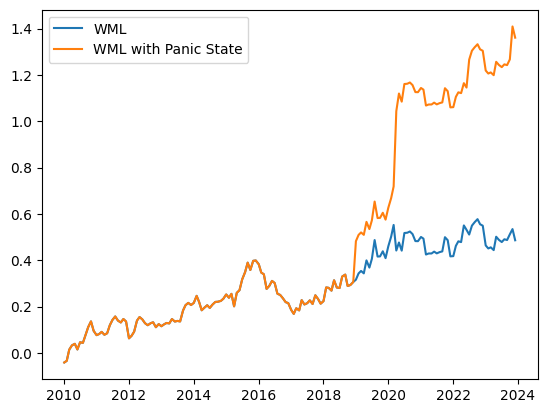

In [11]:
# Plot the cumulative return of the portfolio_return_WML and portfolio_return_with_panic_state, The x axis is the number of months starting from 2016-01, the y axis is the cumulative return
plt.plot(portfolio_return_WML.cumsum(), label='WML')
plt.plot(portfolio_return_with_panic_state.cumsum(), label='WML with Panic State')
plt.legend()
plt.show()

In [12]:
print(len(portfolio_return_WML))
print(len(portfolio_return_with_panic_state))

168
168


In [13]:
# Calculate the cumulative return for the portfolio_return_WML and portfolio_return_with_panic_state
cumulative_return_WML = np.sum(np.array(portfolio_return_WML))
cumulative_return_with_panic_state = np.sum(np.array(portfolio_return_with_panic_state))

print(f'Cumulative return for the WML strategy: {cumulative_return_WML}')
print(f'Cumulative return for the WML strategy with panic state: {cumulative_return_with_panic_state}')

Cumulative return for the WML strategy: 0.4862249349385031
Cumulative return for the WML strategy with panic state: 1.3610271158312006


# Conclusion

The WML strategy with panic state has a higher Sharpe ratio compared to the WML strategy. But it also has a higher beta and skewness smaller than 0.

In [14]:
# Calculate the annualized return for the portfolio_return_WML and portfolio_return_with_panic_state
annualized_return_WML = portfolio_return_WML.mean() * 12
annualized_return_with_panic_state = portfolio_return_with_panic_state.mean() * 12

print(f'Annualized return for the WML strategy: {annualized_return_WML}')
print(f'Annualized return for the WML strategy with panic state: {annualized_return_with_panic_state}')

# Calculate the annualized volatility for the portfolio_return_WML and portfolio_return_with_panic_state
annualized_volatility_WML = np.std(portfolio_return_WML) * np.sqrt(12)
annualized_volatility_with_panic_state = np.std(portfolio_return_with_panic_state) * np.sqrt(12)

print(f'Annualized volatility for the WML strategy: {annualized_volatility_WML}')
print(f'Annualized volatility for the WML strategy with panic state: {annualized_volatility_with_panic_state}')

# Calculate the Sharpe ratio for the portfolio_return_WML and portfolio_return_with_panic_state
sharpe_ratio_WML = annualized_return_WML / annualized_volatility_WML
sharpe_ratio_with_panic_state = annualized_return_with_panic_state / annualized_volatility_with_panic_state

print(f'Sharpe ratio for the WML strategy: {sharpe_ratio_WML}')
print(f'Sharpe ratio for the WML strategy with panic state: {sharpe_ratio_with_panic_state}\n')

Annualized return for the WML strategy: 0.03473035249560737
Annualized return for the WML strategy with panic state: 0.09721622255937148
Annualized volatility for the WML strategy: 0.10660750555856409
Annualized volatility for the WML strategy with panic state: 0.1485937054717844
Sharpe ratio for the WML strategy: 0.3257777425110889
Sharpe ratio for the WML strategy with panic state: 0.6542418620675107



# Choosing the delta

Originally, the delta is set to 0.8. But we can also try to optimize the delta to get a better performance.

In [ ]:
# Try different values of delta
delta_holder = []
cumulative_return_with_panic_state_holder = []
annualized_return_with_panic_state_holder = []
annualized_volatility_with_panic_state_holder = []
sharpe_ratio_with_panic_state_holder = []

for delta in np.linspace(0.1, 2, 20):
    
        market_data['panic_state_indicator'] = (market_data['Short_run_market_return'] < market_data['Long_run_market_return'] - delta * market_data['Long_run_std']).astype(int)
    
        portfolio_return_WML_holder = []
        portfolio_return_with_panic_state_holder = []
    
        monthly_return_holder = []
        panic_state_indicator_holder = []
        rank_holder = []
        this_month_return_holder = []
    
        for i, data in enumerate(monthly_data):
    
            rank = data['signal_simple'].copy()
            monthly_return = data['monthly_log_return'].copy()
            Panic_Indicator = market_data['panic_state_indicator'].copy()
            this_month_return = data['this_month_return'].copy()
    
            rank.name = tickers[i]
            monthly_return.name = tickers[i]
            Panic_Indicator.name = tickers[i]
            this_month_return.name = tickers[i]
    
            monthly_return_holder.append(monthly_return)
            panic_state_indicator_holder.append(Panic_Indicator)
            rank_holder.append(rank)
            this_month_return_holder.append(this_month_return)
    
        monthly_return_df = pd.DataFrame(monthly_return_holder).T
        panic_state_indicator_df = pd.DataFrame(panic_state_indicator_holder).T
        rank_df = pd.DataFrame(rank_holder).T
        this_month_return_df = pd.DataFrame(this_month_return_holder).T
    
        N = 20
        top_N_mask = rank_df.rank(axis=1, method='dense', ascending=False) <= N
        bottom_N_mask = rank_df.rank(axis=1, method='dense', ascending=True) <= N
    
        long_df = this_month_return_df.mask(~top_N_mask, np.nan)
        short_df = this_month_return_df.mask(~bottom_N_mask, np.nan) * -1
        portfolio_return_WML = pd.DataFrame(index=monthly_return_df.index, columns=monthly_return_df.columns)
        portfolio_return_WML.iloc[:, :] = np.nan
    
        portfolio_return_WML[top_N_mask] = long_df[top_N_mask]
        portfolio_return_WML[bottom_N_mask] = short_df[bottom_N_mask]
    
        portfolio_return_with_multiplied_by_1_panic_indicator = this_month_return_df * (1-panic_state_indicator_df)
        portfolio_return_with_multiplied_by_panic_indicator = this_month_return_df * panic_state_indicator_df

        portfolio_return_with_panic_state = pd.DataFrame(index=monthly_return_df.index, columns=monthly_return_df.columns)
        portfolio_return_with_panic_state.iloc[:, :] = np.nan

        portfolio_return_with_panic_state[top_N_mask] = portfolio_return_with_multiplied_by_1_panic_indicator[top_N_mask]
        portfolio_return_with_panic_state[bottom_N_mask] = portfolio_return_with_multiplied_by_1_panic_indicator[bottom_N_mask] * -1

        portfolio_return_with_panic_state[top_N_mask] += portfolio_return_with_multiplied_by_panic_indicator[top_N_mask]
        portfolio_return_with_panic_state[bottom_N_mask] += portfolio_return_with_multiplied_by_panic_indicator[bottom_N_mask]

        portfolio_return_with_panic_state = portfolio_return_with_panic_state.mean(axis=1, skipna=True).dropna()

        portfolio_return_WML = portfolio_return_WML[portfolio_return_WML.index >= portfolio_return_with_panic_state.index[0]]
        portfolio_return_WML = portfolio_return_WML.mean(axis=1, skipna=True)

        portfolio_return_WML = portfolio_return_WML[portfolio_return_WML.index >= '2010-01-01']
        portfolio_return_with_panic_state = portfolio_return_with_panic_state[portfolio_return_with_panic_state.index >= '2010-01-01']

        cumulative_return_with_panic_state = np.sum(np.array(portfolio_return_with_panic_state))
        annualized_return_with_panic_state = portfolio_return_with_panic_state.mean() * 12
        annualized_volatility_with_panic_state = np.std(portfolio_return_with_panic_state) * np.sqrt(12)
        sharpe_ratio_with_panic_state = annualized_return_with_panic_state / annualized_volatility_with_panic_state

        delta_holder.append(delta)
        cumulative_return_with_panic_state_holder.append(cumulative_return_with_panic_state)
        annualized_return_with_panic_state_holder.append(annualized_return_with_panic_state)
        annualized_volatility_with_panic_state_holder.append(annualized_volatility_with_panic_state)
        sharpe_ratio_with_panic_state_holder.append(sharpe_ratio_with_panic_state)

result = pd.DataFrame({
    'delta': delta_holder,
    'cumulative_return_with_panic_state': cumulative_return_with_panic_state_holder,
    'annualized_return_with_panic_state': annualized_return_with_panic_state_holder,
    'annualized_volatility_with_panic_state': annualized_volatility_with_panic_state_holder,
    'sharpe_ratio_with_panic_state': sharpe_ratio_with_panic_state_holder
})

# print(result)

In [19]:
# Show all the results
result.head(20)

,delta,cumulative_return_with_panic_state,annualized_return_with_panic_state,annualized_volatility_with_panic_state,sharpe_ratio_with_panic_state
0,0.1,1.382622,0.098759,0.197958,0.498887
1,0.2,1.523811,0.108844,0.199682,0.545084
2,0.3,0.971059,0.069361,0.185001,0.374925
3,0.4,0.846862,0.060490,0.183692,0.329302
4,0.5,0.996852,0.071204,0.182917,0.389267
5,0.6,0.976206,0.069729,0.177414,0.393029
6,0.7,0.909541,0.064967,0.170282,0.381528
7,0.8,1.363583,0.097399,0.148509,0.655844
8,0.9,1.202553,0.085897,0.143169,0.599968
9,1.0,1.231577,0.087970,0.143894,0.611350


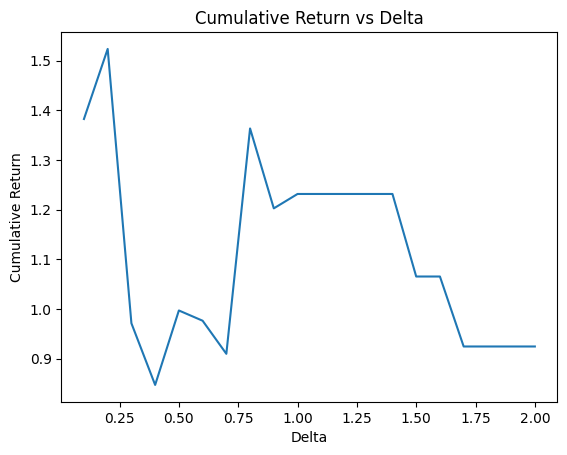

In [18]:

# Plot the cumulative return of the portfolio_return_WML and portfolio_return_with_panic_state, The x axis is the number of months starting from 2016-01, the y axis is the cumulative return
plt.plot(result['delta'], result['cumulative_return_with_panic_state'])
plt.xlabel('Delta')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return vs Delta')
plt.show()



# Some final thoughts

The strategy is very simple yet effective. It is a good strategy to try out if you are interested in momentum strategies. With a good delta, it can improve the traditional momentum strategy significantly and avoid some extreme losses.

Although the best sharpe ratio achieved is 0.34 only, I attribute this to the fact that the strategy is very simple and the universe is limited to the S&P 500 index. It is possible to achieve a higher sharpe ratio with a larger universe and more complex strategies.

Currently, I do the rebalancing monthly. But it is possible to do the rebalancing with longer periods and see if it can improve the performance.